Please note: this uses the Google Cloud Healthcare Natural Languge API, which is deprecated and will be shut down on May 27, 2026. 
Find more information here https://cloud.google.com/healthcare-api/docs/concepts/nlp

In [ ]:
import re
from collections import defaultdict
import os
import csv
from pathlib import Path
from google.oauth2 import service_account
from google.auth.transport.requests import AuthorizedSession
from difflib import SequenceMatcher
from collections import Counter, defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from typing import List, Dict
from tqdm import tqdm
import numpy as np

In [ ]:
ref_path = Path("path/to/your/data/analysis/ref/8_reference.stm") ###
hyp_path = Path("path/to/your/data/analysis/hyp") ###
out_path = Path("path/to/your/data/analysis/results/3. medical/en") ###

JSON_KEY = r"key" ###
PROJECT = "project" ###
LOCATION = "europe-west4"

In [ ]:
def parse_stm_to_dict(stm_path):
    stm_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    with open(stm_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            parts = line.strip().split(maxsplit=6)
            if len(parts) < 7:
                continue
            utt_id = parts[0]
            transcript_id = get_transcript_id(utt_id)
            text = parts[6]

            match = re.search(r'(doctor|patient)_u(\d+)', utt_id)
            if not match:
                continue
            speaker, utt_code = match.groups()
            utt_code = int(utt_code)
            
            text = clean_text(text)

            stm_dict[transcript_id][speaker][utt_code].append(text)

    sorted_stm = {}
    for transcript_id in sorted(stm_dict):
        speakers = stm_dict[transcript_id]

        #sort speakers (doctor first)
        combined_words = []
        for speaker in sorted(speakers, key=lambda s: 0 if s == "doctor" else 1):
            utterances = speakers[speaker]
            for utt_code in sorted(utterances):
                combined_words.extend(utterances[utt_code])

        sorted_stm[transcript_id] = ' '.join(combined_words)

    return sorted_stm

def parse_ctm_to_dict(ctm_path):
    #transcript_id → speaker → utt_code → list of words
    ctm_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    with open(ctm_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            utt_id = parts[0]
            transcript_id = get_transcript_id(utt_id)
            word = parts[4]

            #extract speaker and utterance code
            match = re.search(r'(doctor|patient)_u(\d+)', utt_id)
            if not match:
                continue
            speaker, utt_code = match.groups()
            utt_code = int(utt_code)

            word = clean_text(word)

            ctm_dict[transcript_id][speaker][utt_code].append(word)

    #build sorted output
    sorted_ctm = {}
    for transcript_id in sorted(ctm_dict):
        speakers = ctm_dict[transcript_id]

        #sort speakers (doctor first)
        combined_words = []
        for speaker in sorted(speakers, key=lambda s: 0 if s == "doctor" else 1):
            utterances = speakers[speaker]
            for utt_code in sorted(utterances):
                combined_words.extend(utterances[utt_code])

        sorted_ctm[transcript_id] = ' '.join(combined_words)

    return sorted_ctm

def get_transcript_id(utt_id):
    id = utt_id.split('_')[1]
    id = ''.join(re.findall(r'\d+', id))
    return id

def digits_to_words(text):
    def replace_num(match):
        num = int(match.group())
        return num2words(num, lang='en')

    return re.sub(r"\b\d+\b", replace_num, text)

def clean_text(text):
    text = text.lower()
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)
    text = digits_to_words(text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r'<[^>]+>', '', text).strip()
    text = re.sub(r"unsure(\w+)", r"\1", text)
    text = re.sub(r"(\w+)unsure", r"\1", text)

    return text

In [ ]:
def analyze_medical_text(text):
    credentials = service_account.Credentials.from_service_account_file(
        JSON_KEY,
        scopes=['https://www.googleapis.com/auth/cloud-platform']
    )
    authed_session = AuthorizedSession(credentials)

    url = f"your url here" ###

    payload = {
        "documentContent": text
    }

    response = authed_session.post(url, json=payload)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"API Error {response.status_code}: {response.text}")
    
def extract_entities(api_result):
    if 'entityMentions' not in api_result:
        return []

    return [
        {
            "text": mention['text']['content'].lower(),
            "category": mention['type'],
            "offset": mention['text']['beginOffset']
        }
        for mention in api_result['entityMentions']
    ]

In [ ]:
def tokens(text: str):
    return text.lower().split()

def similarity(a: str, b: str) -> float:
    return SequenceMatcher(None, a, b).ratio()

def align_entities(ref_entities, hyp_entities, fuzzy_correct_threshold=0.90, gap_penalty=-1):
    n, m = len(ref_entities), len(hyp_entities)

    def is_match(a, b):
        return (
            a['text'] == b['text'] or
            similarity(a['text'], b['text']) >= fuzzy_correct_threshold
        )

    def group_similarity(ref_group, hyp_group):
        ref_text = " ".join(r['text'] for r in ref_group)
        hyp_text = " ".join(h['text'] for h in hyp_group)
        return similarity(ref_text, hyp_text)

    # scoring
    def score(ref, hyp):
        if ref is None or hyp is None:
            return gap_penalty
        if is_match(ref, hyp):
            return 2
        return -1

    dp = np.full((n+1, m+1), -9999, dtype=int)
    dp[0, 0] = 0
    back = [[None]*(m+1) for _ in range(n+1)]  # traceback

    for i in range(n+1):
        for j in range(m+1):
            if i > 0 and j > 0:
                val = dp[i-1, j-1] + score(ref_entities[i-1], hyp_entities[j-1])
                if val > dp[i, j]:
                    dp[i, j] = val
                    back[i][j] = ("match", 1, 1)
            if i > 0:
                val = dp[i-1, j] + gap_penalty
                if val > dp[i, j]:
                    dp[i, j] = val
                    back[i][j] = ("del", 1, 0)
            if j > 0:
                val = dp[i, j-1] + gap_penalty
                if val > dp[i, j]:
                    dp[i, j] = val
                    back[i][j] = ("ins", 0, 1)

            #group cases
            if i >= 2 and j >= 1:
                if group_similarity(ref_entities[i-2:i], [hyp_entities[j-1]]) >= fuzzy_correct_threshold:
                    val = dp[i-2, j-1] + 2
                    if val > dp[i, j]:
                        dp[i, j] = val
                        back[i][j] = ("group_ref", 2, 1)
            if i >= 1 and j >= 2:
                if group_similarity([ref_entities[i-1]], hyp_entities[j-2:j]) >= fuzzy_correct_threshold:
                    val = dp[i-1, j-2] + 2
                    if val > dp[i, j]:
                        dp[i, j] = val
                        back[i][j] = ("group_hyp", 1, 2)

    #traceback
    results = []
    i, j = n, m
    while i > 0 or j > 0:
        action, di, dj = back[i][j]
        if action == "match":
            ref = ref_entities[i-1]
            hyp = hyp_entities[j-1]
            if is_match(ref, hyp):
                results.append((ref['text'], hyp['text'], ref['category'], "correct"))
            else:
                results.append((ref['text'], hyp['text'], ref['category'], "substitution"))
        elif action == "del":
            ref = ref_entities[i-1]
            results.append((ref['text'], None, ref['category'], "deletion"))
        elif action == "ins":
            hyp = hyp_entities[j-1]
            results.append((None, hyp['text'], hyp['category'], "insertion"))
        elif action == "group_ref":
            ref_text = " ".join(r['text'] for r in ref_entities[i-2:i])
            hyp_text = hyp_entities[j-1]['text']
            results.append((ref_text, hyp_text, ref_entities[i-1]['category'], "correct"))
        elif action == "group_hyp":
            ref_text = ref_entities[i-1]['text']
            hyp_text = " ".join(h['text'] for h in hyp_entities[j-2:j])
            results.append((ref_text, hyp_text, ref_entities[i-1]['category'], "correct"))
        i -= di
        j -= dj

    return results[::-1]


In [19]:
def model_wer(all_aligned):
    total_errors = 0
    total_ref_tokens = 0

    for alignment in all_aligned.values():
        total_errors += sum(1 for _, _, _, error in alignment if error != "correct")
        total_ref_tokens += len(alignment)

    if total_ref_tokens == 0:
        return 0.0

    return total_errors / total_ref_tokens

In [ ]:
def plot_model_heatmap(all_aligned, model_name, output_dir):
    rows = []
    for transcript_id, alignment_output in all_aligned.items():
        for ref_text, hyp_text, category, error in alignment_output:
            if error == "correct":
                continue
            rows.append({
                "transcript_id": transcript_id,
                "error_type": f"{error}: {category}",
                "count": 1
            })

    if not rows:
        print("No errors to plot.")
        return

    df = pd.DataFrame(rows)
    pivot = df.pivot_table(
        index="transcript_id",
        columns="error_type",
        values="count",
        fill_value=0,
        aggfunc="sum"
    )

    sns.set(font_scale=0.6)
    plt.figure(figsize=(12, max(5, len(all_aligned)*0.1)))

    ax = sns.heatmap(
        pivot,
        cmap="magma_r",
        annot=False,
        linewidths=0.3,
        linecolor="lightgray",
        cbar_kws={'label': 'Count'},
        square=False,
        vmin=0,
        vmax=15
    )

    ax.set_title(f"Medical Error Types per Transcript – {model_name}", fontsize=14)
    ax.set_ylabel("Transcript", fontsize=12)
    ax.set_xlabel("")

    plt.xticks(rotation=70, ha='right', fontsize=6)
    plt.yticks(rotation=0, fontsize=6)

    plt.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    file_name = f"{model_name}_summary_heatmap.svg"
    save_path = os.path.join(output_dir, file_name)
    plt.savefig(save_path, dpi=300)
    print(f"Saved heatmap to: {save_path}")

    plt.show()

In [21]:
def get_full_ref(ref_path):
    full_ref = {}
    stm_dict = parse_stm_to_dict(ref_path)
    transcript_list = sorted(stm_dict.keys())
    for transcript_id in tqdm(transcript_list):
        ref_text = stm_dict[transcript_id]
        assert len(ref_text) <= 10000
    
        ref_response = analyze_medical_text(ref_text)
        ref_entities = extract_entities(ref_response)
        full_ref[transcript_id] = ref_entities
    return full_ref

ref = get_full_ref(ref_path)

100%|██████████| 57/57 [01:18<00:00,  1.37s/it]


In [23]:
model_results = {}

In [ ]:
for subfolder in list(hyp_path.iterdir())[1:6]:
    if subfolder.name.startswith('wav2vec2'):
        print(f"Skipping: {subfolder}")
        continue
    if subfolder.is_dir():
        ctm_folder = subfolder / "ctm"
        if not ctm_folder.exists():
            continue
        matches = list(ctm_folder.glob("*_8.ctm"))

        if matches:
            hyp_file = matches[0]
            print(f"Found: {hyp_file}")
            ctm_dict = parse_ctm_to_dict(hyp_file)

            full_hyp = {} 
            transcript_list = sorted(ctm_dict.keys())
            for transcript_id in tqdm(transcript_list):
                hyp_text = ctm_dict[transcript_id]
                assert len(hyp_text) <= 10000

                hyp_response = analyze_medical_text(hyp_text)
                hyp_entities = extract_entities(hyp_response)
                full_hyp[transcript_id] = hyp_entities

            model_results[subfolder.stem] = full_hyp


Aligning for aws-transcribe: 100%|██████████| 57/57 [00:13<00:00,  4.24it/s]


WER for aws-transcribe: 10.24%
Saved heatmap to: C:\Users\Topicus\Documents\Datasets\analysis\results\3. medical\en\aws-transcribe_summary_heatmap.svg


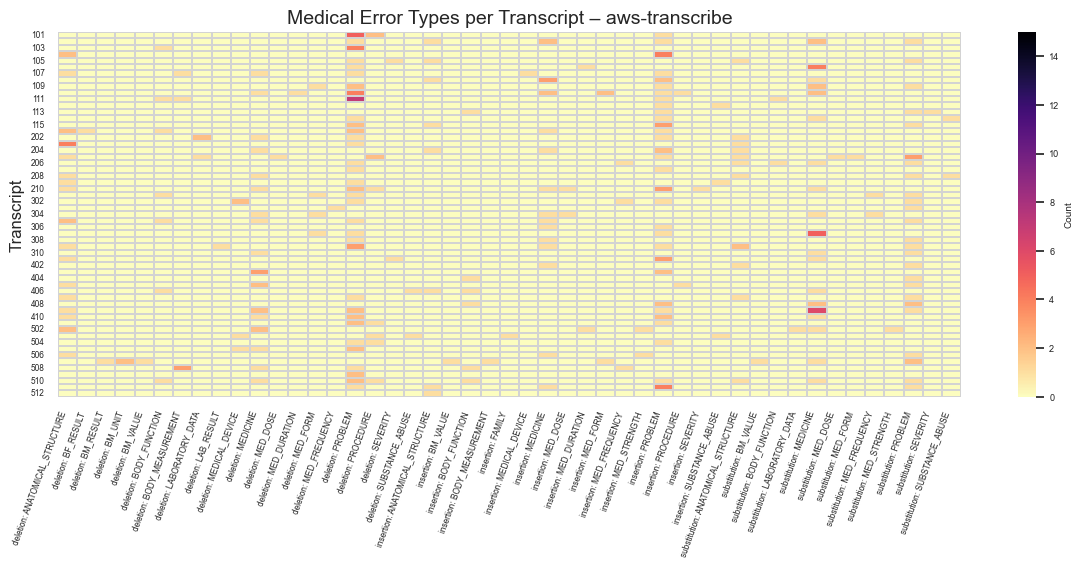

Aligning for whisper-base: 100%|██████████| 57/57 [00:10<00:00,  5.24it/s]


WER for whisper-base: 30.04%
Saved heatmap to: C:\Users\Topicus\Documents\Datasets\analysis\results\3. medical\en\whisper-base_summary_heatmap.svg


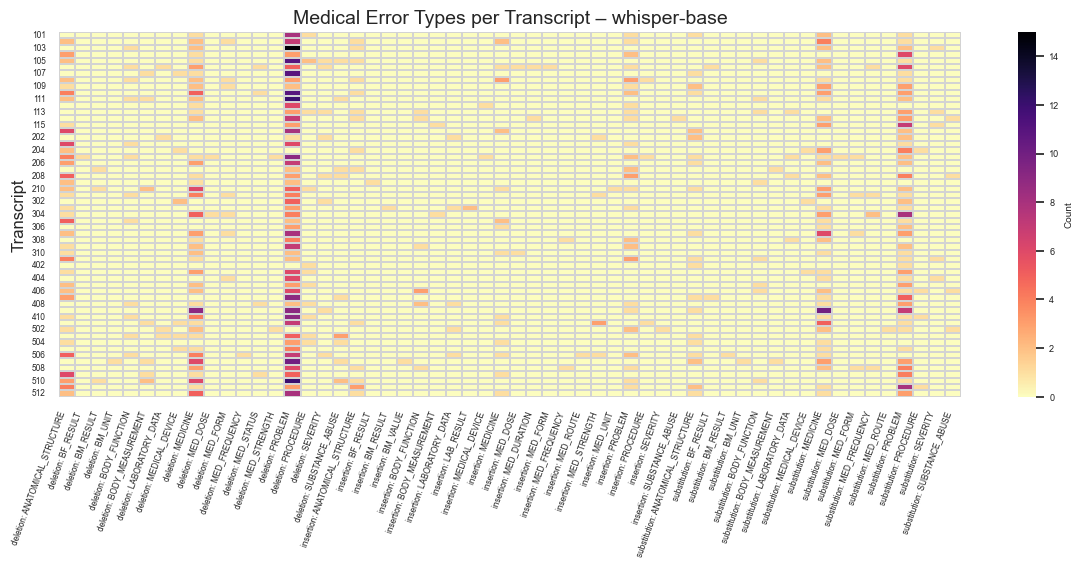

Aligning for whisper-large-v3: 100%|██████████| 57/57 [00:11<00:00,  4.84it/s]


WER for whisper-large-v3: 14.89%
Saved heatmap to: C:\Users\Topicus\Documents\Datasets\analysis\results\3. medical\en\whisper-large-v3_summary_heatmap.svg


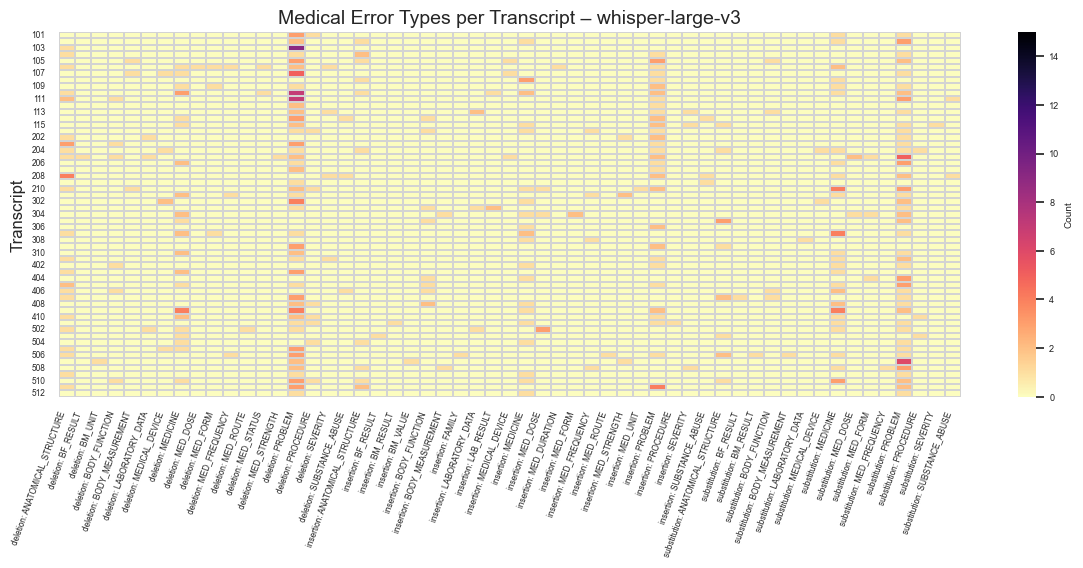

Aligning for whisper-large-v3-turbo: 100%|██████████| 57/57 [00:12<00:00,  4.64it/s]


WER for whisper-large-v3-turbo: 15.65%
Saved heatmap to: C:\Users\Topicus\Documents\Datasets\analysis\results\3. medical\en\whisper-large-v3-turbo_summary_heatmap.svg


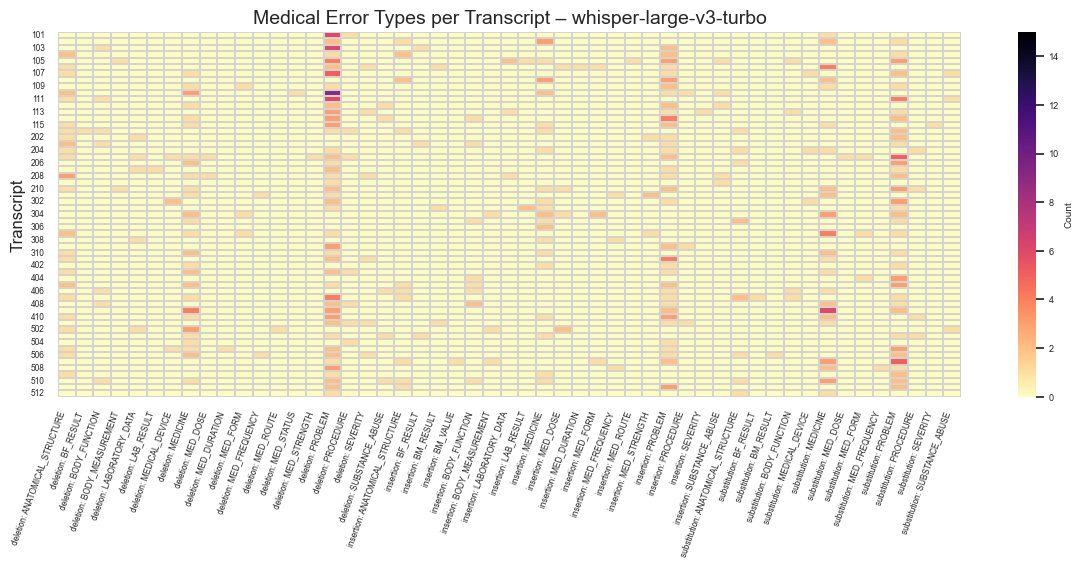

In [29]:
for model_name, hyp_dict in model_results.items():
    all_aligned = {}
    for transcript_id in tqdm(hyp_dict.keys(), desc=f"Aligning for {model_name}"):
        alignment = align_entities(ref[transcript_id], hyp_dict[transcript_id])
        all_aligned[transcript_id] = alignment

    wer = model_wer(all_aligned)
    print(f"WER for {model_name}: {wer:.2%}")

    plot_model_heatmap(all_aligned, model_name, out_path)
